# Time_Series_Forecasting_Predicting_Stock_Prices_Using_An_ARIMA_Model

* Ref: https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70
* Data: https://finance.yahoo.com/quote/TSLA/history?period1=1436486400&period2=1594339200&interval=1d&filter=history&frequency=1d

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## 1. Load data

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/TSLA.csv',
                 header=0,
                 index_col=0,
                 parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-07-10,262.220001,263.000000,257.820007,259.149994,259.149994,2610900
2015-07-13,262.250000,262.549988,256.049988,262.160004,262.160004,2960300
2015-07-14,262.100006,265.989990,260.510010,265.649994,265.649994,1907600
2015-07-15,266.739990,267.489990,262.079987,263.140015,263.140015,2021600
2015-07-16,264.220001,267.200012,263.160004,266.679993,266.679993,1616000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-07-10 to 2020-07-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


* 畫圖看分佈，只看 Close 欄位的股價

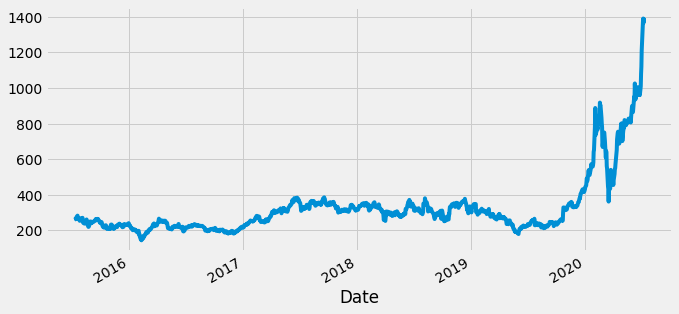

In [ ]:
# Show the time series distribution
fig, ax = plt.subplots(figsize=(10, 5))
df['Close'].plot(ax=ax)
plt.show()

## 2. Analysis

* 檢查是否有 bias
    * 1 sample student test
      * null hypothesis: there is no effective difference between the observed sample mean and the hypothesized or stated population mean—i.e., that any measured difference is due only to chance. 
      * 就是說 sample mean = population mean
* 檢查是否有 autocorrelation
    * Ljung-Box test
    * 畫圖
* 檢查是否是 stationary
    * Dickey-Fuller test
      * null hypothesis: time series 是 non-stationary 的
      * Test statistics  <  critical value  →  reject null hypothesis
      * $p$ -value  <  0.05  →  reject null hypothesis
      * ADF < 0 (ADF 就是 test statistics)
* 做 seasonal decomposition

In [ ]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller # Use augmented dickey-fuller test to check stationality

def check_time_series(time_series, window=12, bias=True, adf=True):
  # determin rolling statistics
  rolling_mean = time_series.rolling(window).mean()
  rolling_std = time_series.rolling(window).std()

  # plot rolling statistics
  fig, ax = plt.subplots(figsize=(10, 5))
  time_series.plot(ax=ax, color='blue', label='original')
  rolling_mean.plot(ax=ax, color='red', label='rolling mean')
  rolling_std.plot(ax=ax, color='black', label='rolling std')
  plt.legend()
  plt.title('Rolling mean and standard deviation')
  plt.show()

  # perform 1 sample student test
  # null hypothesis: sample mean = population mean
  if bias:
    student_test = stats.ttest_1samp(time_series, 0)[1]
    print(f"Students' criterion: p={student_test}")
    if student_test < 0.05:
      print("Because p < 0.05, we reject the null hypothesis.")
      print("--> The sample mean is not equal to population mean.\n")

  # perform Dickey-Fuller test
  # null hypothesis: the time series is non-stationary 
  if adf:
    print('Results of Dickey-Fuller test:')
    adf_test = adfuller(time_series, autolag='AIC') # AIC: Akaike information criterion (AIC), the smaller AIC the better model
    index = [
      'Test statistics (ADF)',
      'p-value',
      'Number of lags used',
      'Number of observations used'
    ]
    adf_results = pd.Series(adf_test[:4], index=index)
    for k, v in adf_test[4].items():
      adf_results[f'Critical value ({k})'] = v
    print(adf_results)
    if adf_results[1] < 0.05:
      print("Because p < 0.05, we reject the null hypothesis")
      print("--> The time series is stationary.")

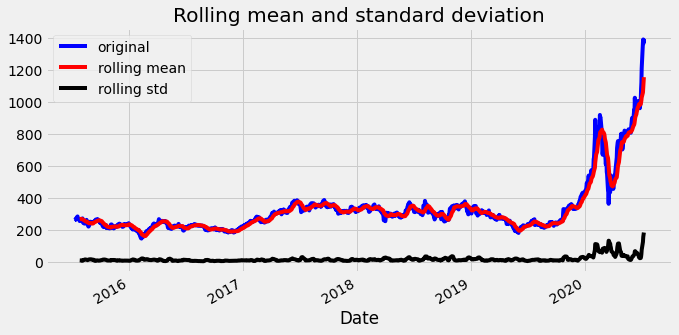

Students' criterion: p=0.0
Because p < 0.05, we reject the null hypothesis.
--> The sample mean is not equal to population mean.

Results of Dickey-Fuller test:
Test statistics (ADF)             3.980003
p-value                           1.000000
Number of lags used              23.000000
Number of observations used    1235.000000
Critical value (1%)              -3.435656
Critical value (5%)              -2.863883
Critical value (10%)             -2.568018
dtype: float64


In [ ]:
check_time_series(df['Close'])

* Student's test $p$-value < 0.05 $\rightarrow$  reject null hypothesis
* Dickey-Fuller test $p$-value > 0.05 $\rightarrow$ not reject null hypothesis (i.e. this time series is non-stationary)
  * Need to apply differencing to make the time series stationary

In [ ]:
# 用已有的函數畫圖
def plot_lags_autocorrelation_acf_pacf(time_series, nlags=50): # 只畫前 50 個 lags
  fig, ax = plt.subplots(2, 2, figsize=(18, 8))
  # 畫 lag_plot(), autocorrelation_plot()
  pd.plotting.lag_plot(time_series, ax=ax[0][0])
  pd.plotting.autocorrelation_plot(time_series, ax=ax[0][1])

  # 畫 plot_acf(), plot_pacf()
  from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
  plot_acf(time_series, lags=nlags, ax=ax[1][0]) 
  plot_pacf(time_series, lags=nlags, ax=ax[1][1])

  plt.tight_layout()
  plt.show()

# 自己手動計算 ACF 和 PACF 然後畫圖
def plot_calculated_acf_and_pacf(time_series, nlags=50): # 只畫前 50 個 lags
  import numpy as np
  from statsmodels.tsa.stattools import acf, pacf
  lag_acf = acf(time_series, nlags=nlags)
  lag_pacf = pacf(time_series, nlags=nlags, method='ols') # OLS: ordinary least square

  fig, ax = plt.subplots(1, 2, figsize=(18, 4))
  ax[0].plot(lag_acf)
  ax[0].axhline(y=0, linestyle='--', color='gray')
  ax[0].axhline(y=-1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[0].axhline(y=1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[0].set_title('Autocorrelation Function')

  ax[1].plot(lag_pacf)
  ax[1].axhline(y=0, linestyle='--', color='gray')
  ax[1].axhline(y=-1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[1].axhline(y=1.96/np.sqrt(len(time_series)), linestyle='--', color='gray')
  ax[1].set_title('Partical Autocorrelation Function')

  plt.tight_layout()
  plt.show()

def plot_seasonal_decomposition(time_series, model): # model=additive or multiplicative
  from statsmodels.tsa.seasonal import seasonal_decompose
  decomposition = seasonal_decompose(time_series, model=model)
  # 只畫一張圖，會很小，都擠在一起
  # fig = decomposition.plot()

  # 改成單獨畫每張圖
  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  fig, ax = plt.subplots(3, 1, figsize=(18, 9))
  trend.plot(ax=ax[0])
  ax[0].set_ylabel('Trend')

  seasonal.plot(ax=ax[1])
  ax[1].set_ylabel('Seasonal')

  residual.plot(ax=ax[2])
  ax[2].set_ylabel('Residual')

  plt.tight_layout()
  plt.show()

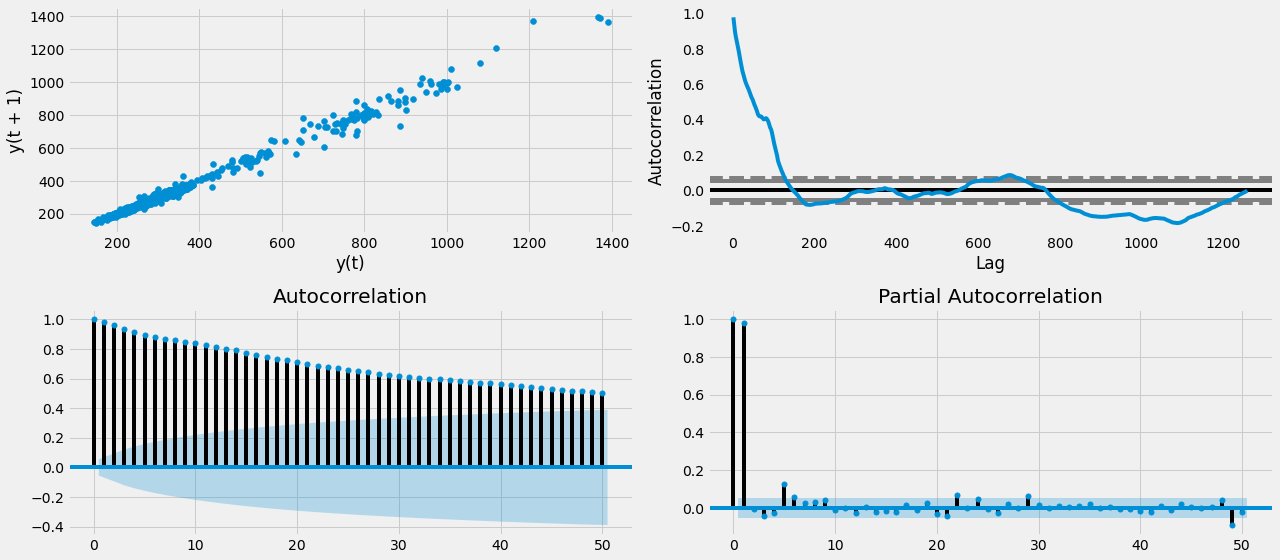

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


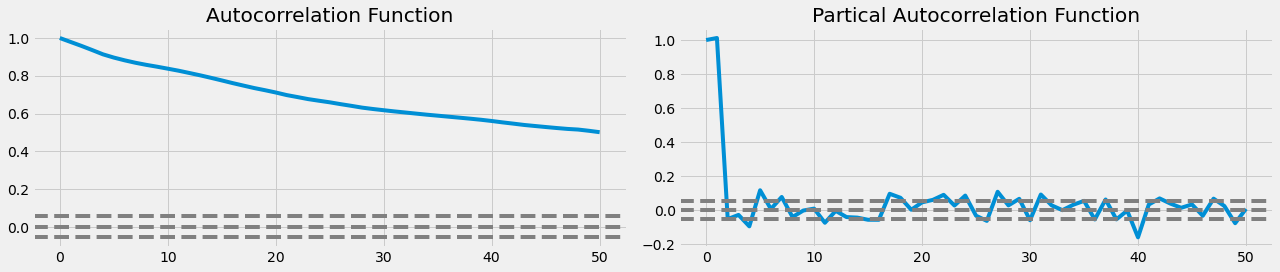

In [ ]:
plot_lags_autocorrelation_acf_pacf(df['Close'])
plot_calculated_acf_and_pacf(df['Close'])

# plot_seasonal_decomposition(df['Close'], model='additive')
# 會有 ValueError: You must specify a freq or x must be a pandas object with a timeseries index with a freq not set to None
# 原因是因為 df['Close'] 是每天的資料，所以日期的 index 沒有週期性，必須要指定 freq 或是讓日期的 index 有週期性 

## 3. Forecast

使用前 70% 當 training samples 後 30% 當 testing samples

In [ ]:
df_training = df[:int(len(df) * 0.7)]
df_testing = df[int(len(df) * 0.7):]

print(df_training.index.min(), df_training.index.max())
print(df_testing.index.min(), df_testing.index.max())

2015-07-10 00:00:00 2019-01-08 00:00:00
2019-01-09 00:00:00 2020-07-09 00:00:00


把 training 和 testing 改成 numpy array

In [ ]:
print(type(df_training))
print(type(df_testing))

training = df_training['Close'].values
testing = df_testing['Close'].values

print(type(training))
print(type(testing))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


不是一次預測全部 testing 的資料，而是採用一次只預測一個數值 $\hat{y}(t)$ ，然後再把 $y(t)$ 加入後預測 $\hat{y}(t+1)$ 的方式來做預測

In [ ]:
history = [x for x in training]
y_hat = [] # 這個是 prediction 的結果
num_of_testing = len(testing) # 有這麼多 testing 的資料點

# 隨便選定 ARIMA 的參數數值
# 本來 p, q 的值要從 PACF 和 ACF 圖中讀出來的，但是從圖中看不到合適的數值
# 如果 Dicky-Fuller test 的 p > 0.05 表示 time series 是 non-stationary 時才要做 differencing, i.e. d > 0
# 雖然前面的分析 p < 0.05 顯示但是這邊仍然做 differencing
p = 4 
d = 1
q = 0

from statsmodels.tsa.arima_model import ARIMA  

for i in range(num_of_testing): # 一次只預測 testing 的一個資料點
  model = ARIMA(history, order=(p, d, q))
  model_fitted = model.fit(disp=0) # disp < 0 表示不要輸出 convergence information
  forecast, stderr, conf_int = model_fitted.forecast() # forecast, stderr, conf_int 都是 array, conf_int 是 2d array
  
  y_hat.append(forecast[0]) # 把預測的結果加入到 y_hat 裡面，因為 forecast 是 1d array，我只要取出數值，所以用 forecast[0]
  history.append(testing[i]) # 把真正的結果加入到 history 裡面，提供下一步預測使用

In [ ]:
# 當 testing 中的所有資料點都預測完以後，要把預測的結果和真正的結果比較好壞
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(testing, y_hat)  
print(f'The Mean Squared Error for testing data is {mse}')

The Mean Squared Error for testing data is 741.0594841313109


最後畫圖比較預測和真正的結果

In [ ]:
df_testing = df[int(len(df) * 0.7):]
df_testing_close = df_testing[["Close"]]
df_testing_close.head()

,Close
Date,
2019-01-09,338.529999
2019-01-10,344.970001
2019-01-11,347.260010
2019-01-14,334.399994
2019-01-15,344.429993


In [ ]:
len(df_testing_close), len(y_hat)

(378, 378)

In [ ]:
df_testing_close["prediction"] = y_hat
df_testing_close.rename(columns={"Close": "Actual"}, inplace=True)
df_testing_close.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Actual,prediction
Date,,
2019-01-09,338.529999,336.275287
2019-01-10,344.970001,338.048241
2019-01-11,347.260010,344.351835
2019-01-14,334.399994,347.453566
2019-01-15,344.429993,334.905443


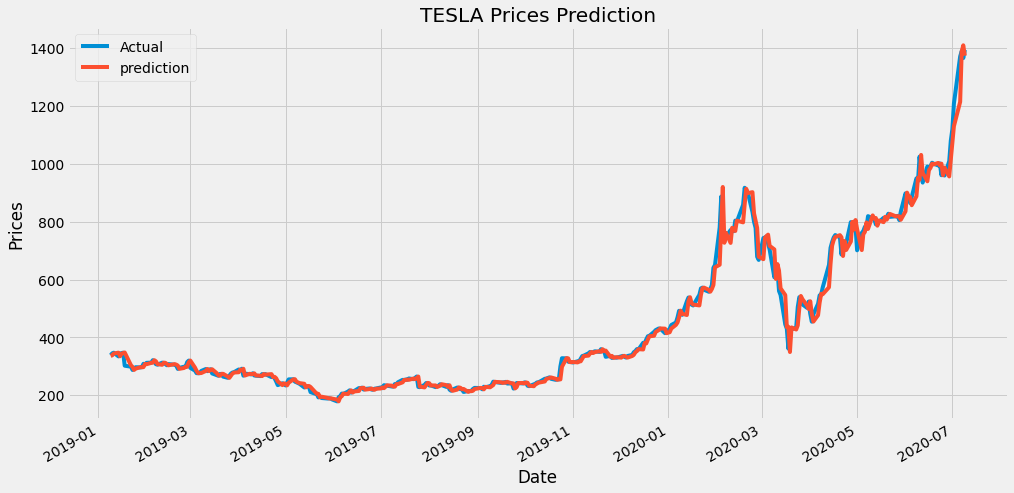

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
df_testing_close.plot(ax=ax)
plt.title('TESLA Prices Prediction')  
plt.xlabel('Date')  
plt.ylabel('Prices') 
plt.show()